# NSF

In [10]:
# Libraries

from os.path import join
from os import listdir
from bs4 import BeautifulSoup
import pandas as pd

## 1. Parsing XML

In [ ]:
# Option 1: List of file paths for all years

years = list(range(2002,2021))
filelist = []

for year in years:
    folder_path = join('data/nsf/'+str(year))
    filelist.extend([join(folder_path,f) for f in listdir(folder_path)])

In [ ]:
# Option 2: Filelist year by year

year = 2020
folder_path = join('data/nsf/'+str(year))
filelist = []
filelist.extend([join(folder_path,f) for f in listdir(folder_path)])

In [ ]:
# Option 3: File by file (testing purposes)

xmlfile = open('data/nsf/2002/0200014.xml','r')
xml_soup = BeautifulSoup(xmlfile,'xml')
for element in xml_soup.find_all():
    for column in list(xml_df):
        if(element.name==column):
            dict_aux[column] = element.string

xml_df = xml_df.append(dict_aux,ignore_index=True)

In [101]:
# XML Schema

xsd_file = open('data/nsf/Award.xsd','r')
xsd_soup = BeautifulSoup(xsd_file)

tags = []
for element in xsd_soup.find_all('xsd:element'):
    tags.append(element['name'])

In [102]:
# Build dataframe (Options 1 & 2)

xml_df = pd.DataFrame(columns=tags)
dict_aux = {}

for file in filelist:
    xmlfile = open(file,'r')
    xml_soup = BeautifulSoup(xmlfile,'xml')
    for element in xml_soup.find_all(): 
        for column in list(xml_df):
            if(element.name==column):
                dict_aux[column] = element.string
    xml_df = xml_df.append(dict_aux,ignore_index=True)
    dict_aux = {}

In [104]:
# Write dataframe to csv file (Option 2: year by year)

xml_df.to_csv('data/nsf/nsf_2020.csv')

In [53]:
# Load csvs into joint dataframe (Option 2: year by year)

columns_dates = ['AwardEffectiveDate','AwardExpirationDate']
nsf_list = []

for file in listdir("data/nsf"):
    if file.endswith(".csv"):
        df = pd.read_csv(join('data/nsf',file),parse_dates=columns_dates)
        nsf_list.append(df)

nsf = pd.concat(nsf_list)
nsf.to_csv('data/nsf/nsf.csv')

## 2. Preprocessing

In [45]:
# Load csv (Option 1: all in one)

columns_dates = ['AwardEffectiveDate','AwardExpirationDate','MinAmdLetterDate','MaxAmdLetterDate','StartDate']
nsf = pd.read_csv('data/nsf/nsf.csv',parse_dates=columns_dates)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (28,32,33,35,44,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [51]:
# Duration in days
nsf['durationAward'] = (nsf['AwardExpirationDate'] - nsf['AwardEffectiveDate']).dt.days

# Extract years
nsf['awardEffectiveYear'] = pd.DatetimeIndex(nsf['AwardEffectiveDate']).year
nsf['awardExpirationYear'] = pd.DatetimeIndex(nsf['AwardExpirationDate']).year
nsf['startYear'] = pd.DatetimeIndex(nsf['StartDate']).year
nsf = nsf.fillna({'startYear':0})
nsf = nsf.astype({"startYear":'int'}) 

In [52]:
# Find columns with most of their values nulls

cols_to_drop = []

for col in nsf.columns:
    if(nsf[col].isnull().sum() > 12000):
        cols_to_drop.append(col)

In [53]:
# Drop useless columns

cols_to_drop.extend(['Unnamed: 0','Unnamed: 0.1','Code','LongName.1','Code.1','Name.1','Code.2','Code.3'])

nsf = nsf.drop(columns=cols_to_drop)

In [54]:
nsf.head()

,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,Value,LongName,SignBlockName,AbstractNarration,MinAmdLetterDate,MaxAmdLetterDate,...,RoleCode,Name,ZipCode,CountryName,StateName,StateCode,durationAward,awardEffectiveYear,awardExpirationYear,startYear
0,Collaborative Research: Framework: Software: N...,2018-10-01,2022-09-30,700000,Standard Grant,Office of Advanced Cyberinfrastructure (OAC),Seung-Jong Park,This award supports the design and implementat...,2018-09-12,2018-09-12,...,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,837251135,United States,Idaho,ID,1460,2018,2022,2018
1,CRI: CI-P: Creating the Largest Speech Emotion...,2018-09-01,2021-02-28,115390,Standard Grant,Division Of Computer and Network Systems,Tatiana Korelsky,This community infrastructure planning project...,2018-07-25,2020-03-30,...,Principal Investigator,University of Texas at Dallas,750803021,United States,Texas,TX,911,2018,2021,2018
2,Collaborative Research: Targeted Observation b...,2018-09-01,2021-08-31,588488,Continuing Grant,Div Atmospheric & Geospace Sciences,Chungu Lu,Storm-generated boundaries are the focal point...,2018-08-24,2020-10-15,...,Co-Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,803090429,United States,Colorado,CO,1095,2018,2021,2018
3,CAREER: Merging geoscience research and educat...,2019-08-15,2024-07-31,298009,Continuing Grant,Division Of Earth Sciences,Steven Whitmeyer,Mountain ranges have significant impacts on wa...,2019-06-14,2019-06-14,...,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,778433115,United States,Texas,TX,1812,2019,2024,2019
4,Collaborative Research: RUI: A Half Century of...,2018-09-01,2021-08-31,412626,Standard Grant,Office of Polar Programs (OPP),Colene Haffke,Meltwater reaching the base of a glacier behav...,2018-07-25,2018-07-25,...,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,997757880,United States,Alaska,AK,1095,2018,2021,2018


In [57]:
nsf.dtypes

AwardTitle                     object
AwardEffectiveDate     datetime64[ns]
AwardExpirationDate    datetime64[ns]
AwardAmount                     int64
Value                          object
LongName                       object
SignBlockName                  object
AbstractNarration              object
MinAmdLetterDate       datetime64[ns]
MaxAmdLetterDate       datetime64[ns]
AwardID                       float64
FirstName                      object
LastName                       object
StartDate              datetime64[ns]
RoleCode                       object
Name                           object
ZipCode                        object
CountryName                    object
StateName                      object
StateCode                      object
durationAward                   int64
awardEffectiveYear              int64
awardExpirationYear             int64
startYear                       int64
dtype: object

## 3. Descriptive analysis

### Award Amount

In [43]:
nsf['AwardAmount'].mean()

509660.8300755549

<AxesSubplot:>

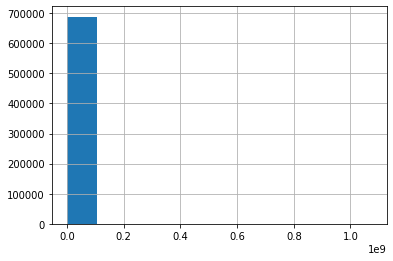

In [44]:
nsf['AwardAmount'].hist()

### Value

In [23]:
nsf['Value'].value_counts()

Standard Grant                       478017
Continuing Grant                     108762
Continuing grant                      72387
Fellowship Award                      10611
Fellowship                             8865
Cooperative Agreement                  5247
Contract Interagency Agreement         2232
Interagency Agreement                  1596
Contract                                333
BOA/Task Order                          294
Fixed Price Award                       102
Fixed Amount Award                       51
Intergovernmental Personnel Award         6
Personnel Agreement                       3
Name: Value, dtype: int64

### Country Name

In [24]:
nsf['CountryName'].value_counts()

United States      676689
Bermuda               336
Canada                192
United Kingdom        162
France                 99
Germany                81
Uruguay                60
Sweden                 45
Switzerland            30
Australia              24
Austria                12
Denmark                12
New Zealand            12
Italy                   9
Russia                  9
Netherlands             9
Spain                   6
Japan                   6
Puerto Rico             6
Paraguay                6
Finland                 6
Sri Lanka               3
Ukraine                 3
Turkey                  3
Colombia                3
Estonia                 3
Belgium                 3
Israel                  3
Mexico                  3
Germany, Berlin         3
Venezuela               3
Antarctica              3
Australasia             3
Taiwan                  3
Cameroon                3
India                   3
South Africa            3
Name: CountryName, dtype: int64

### State Name

In [25]:
nsf['StateName'].value_counts()

California              85851
New York                52173
Massachusetts           45240
Texas                   36471
Pennsylvania            35313
Illinois                29883
Michigan                22875
North Carolina          21090
Florida                 20571
Virginia                19275
Colorado                18813
Maryland                17589
Ohio                    17370
Georgia                 17256
Indiana                 16530
New Jersey              16380
Washington              15879
Arizona                 15525
Wisconsin               11946
District of Columbia    11568
Minnesota               10599
Oregon                  10038
Connecticut              9348
Missouri                 8631
Tennessee                8184
Rhode Island             7632
Iowa                     7116
Utah                     7002
South Carolina           6408
Alabama                  6069
Louisiana                6033
New Mexico               5409
Kansas                   4740
Hawaii    

### Duration Award

In [58]:
nsf['durationAward'].mean()

1197.8278533520404

<AxesSubplot:>

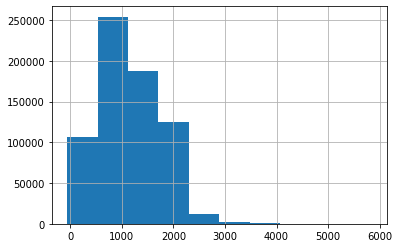

In [59]:
nsf['durationAward'].hist()

### Start Year

In [63]:
nsf['startYear'].value_counts()

2009    45012
2010    39852
2020    39789
2019    38256
2015    38160
2016    38031
2018    37989
2017    36591
2012    36195
2007    35517
2011    34710
2008    34356
2014    34200
2013    33891
2003    33483
2006    32277
2004    31401
2005    30234
2002    22851
0       11556
2021     3294
2001      351
2000      243
1999      150
1998       78
1997       30
1996        3
1995        3
1994        3
Name: startYear, dtype: int64

### Award Effective Year

In [61]:
nsf['awardEffectiveYear'].value_counts()

2009    45714
2010    41463
2016    38979
2015    38787
2018    37806
2020    37545
2012    36918
2017    36591
2007    36354
2019    36333
2014    35949
2011    35856
2008    35235
2013    35106
2003    34701
2004    32766
2006    32649
2005    31221
2002    22032
2021     5469
2001      996
2000       27
2022        6
1995        3
Name: awardEffectiveYear, dtype: int64

### Award Expiration Year

In [62]:
nsf['awardExpirationYear'].value_counts()

2021    66390
2013    42276
2012    38079
2015    37125
2014    37110
2018    36681
2016    36573
2017    36411
2011    36120
2019    35601
2022    35214
2010    34395
2009    31824
2020    31374
2008    30864
2007    28860
2023    24183
2006    23520
2005    15138
2004    10545
2024     8004
2003     5013
2025     4767
2026     1539
2002      882
2027        9
2001        9
Name: awardExpirationYear, dtype: int64

## 4. Corpus processing

In [82]:
# The list of abstracts is the corpus
nsf_corpus_raw = nsf['AbstractNarration']

# Checking NAs (tokenizer will not work with them)
nsf_corpus_raw.isnull().sum()

In [104]:
# Dropping NAs
nsf_corpus_raw = nsf_corpus_raw.dropna()
nsf_corpus_raw.isnull().sum()

### 4.1 Tokenization & Homogeneization
Includes:
- Filtering (removing capitals)
- Cleaning (removing stopwords)
- Lemmatization

In [97]:
# Libraries

from nltk import download
# download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [109]:
wnl = WordNetLemmatizer()

stopwords_en = stopwords.words('english')

# Initialize ouput corpus
nsf_corpus_clean = []

ndocs = len(nsf_corpus_raw)
for n, text in enumerate(nsf_corpus_raw):
    if not n%100:
        print('\rTokenizing document', n, 'out of', ndocs, end='', flush=True)

    # Tokenize each text entry. 
    tokens = word_tokenize(text)
    tokens_filtered = [el.lower() for el in tokens if el.isalnum()]
    tokens_lemmatized = [wnl.lemmatize(el) for el in tokens_filtered]
    tokens_clean = [token for token in tokens_lemmatized if token not in stopwords_en]    
    
    # Add the new token list as a new element to corpus_clean (that will be a list of lists)
    nsf_corpus_clean.append(tokens_clean)

print('\n\n The corpus has been tokenized. Check the result for the first abstract:')
print(nsf_corpus_raw[0])
print(nsf_corpus_clean[0])



 The corpus has been tokenized. Check the result for the first abstract:
This award supports the design and implementation of a software framework to simulate the movement of water at various scales. Understanding the movement and availability of water locally and across the country is of paramount importance to economic productivity and human health of our nation. Hydrologic scientists, are actively tackling these challenges using increasingly complex computational methods. However, modeling advances have not been easily translated to the broader community of scientists and professionals due to technical barriers to entry. This software platform draws from computer models and employs supercomputers capable of analyzing big data to provide unprecedented simulations of water movement over the continental US. Combining hydrologists and computer scientists the team behind the project envision a broad community of users who will have multiple ways to interact with the software framework.

In [111]:
df = pd.DataFrame(data={"tokens": nsf_corpus_clean})
df.to_csv("data/nsf/nsf_tokens.csv", sep=';',index=False)

### 4.2 Vectorization

## 5. Topic modelling